<a href="https://colab.research.google.com/github/BitKnitting/FitHome_Analysis/blob/master/notebooks/Cost%20of%20Leaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leaks
This notebook identifies the amount of electricity that is leaking from a home's total electricity use.

A [study by the NRDC](https://www.nrdc.org/resources/home-idle-load-devices-wasting-huge-amounts-electricity-when-not-active-use) found the homes in the study on average wasted nearly 23% of their electricity consumption on devices that were not being used but were slurping up electricity.

After HVAC, Leaks are one of the largest consumers of electricity.

- How much electricity is this house leaking?
- What percent of the total amount of electricity used is due to leakage?
- How much money is lost each year paying for leaked electricity?

How much is this house leaking?  What percent is it of the total amount of electricity used?  How much money is being payed to the electricity company for leakage?

In [0]:
import pandas as pd

# Data
There are two ways we can get the data:
## Directly from Firebase
- retrieve the readings into a json file.

In [2]:
%%time
!curl 'https://fithome-9ebbd.firebaseio.com/flower-09282019/readings.json?print=pretty' > monitor.json  

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7280k  100 7280k    0     0  24.8M      0 --:--:-- --:--:-- --:--:-- 24.8M
CPU times: user 14.4 ms, sys: 8.48 ms, total: 22.9 ms
Wall time: 1.3 s


In [3]:
# @title Put into a Pandas dataframe
%%time
df_needs_reshape = pd.read_json("monitor.json","r", encoding="utf8")
df_reshaped = df_needs_reshape.T
df_reshaped.head()

CPU times: user 1min 41s, sys: 300 ms, total: 1min 41s
Wall time: 1min 41s


In [0]:
# The datetime is in UTC time.  We are in Kirkland, WA
df_reshaped.index = df_reshaped.index.tz_localize('UTC').tz_convert('US/Pacific')


In [5]:
# @title Start Date and End Data of Series
print('Start date: {}'.format(df_reshaped.index.min()))
print('End   date: {}'.format(df_reshaped.index.max()))
time_between = df_reshaped.index.max() - df_reshaped.index.min()
print('\n\nElapsed time: {}'.format(time_between))

Start date: 2019-10-11 13:46:35-07:00
End   date: 2019-10-20 05:46:55-07:00


Elapsed time: 8 days 16:00:20


# Save the Data
We will save the data locally so we can use it offline.  The columns will be the date, current reading, power reading.  We're not saving the header.

In [0]:

df_reshaped.to_csv('data/monitor.csv',header=False)

# Read Local Data
If we're not connected to the net, we can still analyze a dataset.  When we load the local dataset, we want the date column to be our datetime index.

In [0]:
df_reshaped = pd.read_csv('data/monitor.csv',names=['date','I','P'])
df_reshaped['datetime'] = pd.to_datetime(df_reshaped['date'])
df_reshaped = df_reshaped.set_index('datetime')
df_reshaped.drop(['date'],axis=1,inplace=True)
df_reshaped.head()

,I,P
datetime,,
2019-10-11 13:46:35-07:00,5.039,572.1619
2019-10-11 13:46:40-07:00,5.059,575.0713
2019-10-11 13:46:45-07:00,5.032,572.7318
2019-10-11 13:46:50-07:00,5.037,573.5241
2019-10-11 13:46:56-07:00,5.042,573.4320


# Describe the Data
Let's look at some interesting stats

In [6]:
# @title Interesting Data Stats
df_reshaped.describe()

,I,P
count,124042.000000,124042.000000
mean,6.931820,747.045991
std,5.029362,568.633258
min,0.002000,0.000320
25%,2.945000,309.261425
50%,5.286000,547.431050
75%,10.198000,1120.173000
max,43.649000,4820.673000


# Box Plot
The box plot gives us a quick summary on how the readings are distributed.

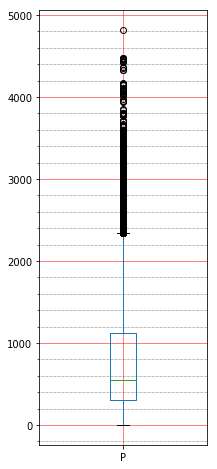

In [7]:
# @title Box Plot
ax = df_reshaped['P'].plot.box(figsize=(3,8))
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

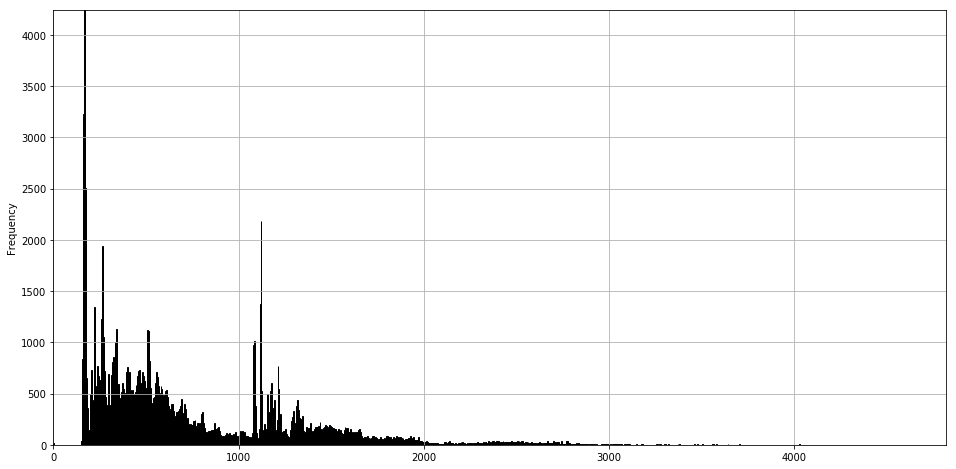

In [8]:
 # @title Histogram Distribution
 df_reshaped['P'].plot.hist(bins=1000, grid=True, edgecolor='k',figsize=(16,8)).autoscale(enable=True, axis='both', tight=True)


# Amount Leaking
After putting the readings into 1,000 bins, we take the first bin to identify the amount of electricity that leaks.

In [17]:
# @title Determine amount Leaking
df_bins = df_reshaped['P'].value_counts(bins=1000)

left_bin = df_bins.index[0].left
right_bin = df_bins.index[0].right

amount_leaking = int(round((right_bin + left_bin) / 2))
print('***************\nAmount of leakage: {}w\n***************\n'.format(amount_leaking))
print('Highest Frequency bins: \n{}'.format(df_bins.head(10)))

***************
Amount of leakage: 166w
***************

Highest Frequency bins: 
(163.903, 168.724]      4245
(159.083, 163.903]      3230
(168.724, 173.545]      2504
(1118.396, 1123.217]    2182
(173.545, 178.365]      2044
(260.317, 265.137]      1942
(1113.576, 1118.396]    1378
(216.931, 221.751]      1341
(265.137, 269.958]      1257
(255.496, 260.317]      1231
Name: P, dtype: int64


# Leakage as Percent of Total
How much of the total amount of electricity used due to leakage?  We'll figure this out by taking an hourly resample.  If the hour has less than 600 samples, we feel it doesn't have enough sample to represent the hour.

In [18]:
enough_samples = df_reshaped['P'].resample(rule='H').count() > 600
df_kWh = df_reshaped['P'].resample(rule='H').mean()[enough_samples]/1000
display(df_kWh.describe())
hour_waste = amount_leaking/1000
percent_of_total = hour_waste/df_kWh.mean()*100
print('\n**************\nThe percentage of total amount of electricity used by leakage: {0:.2f}%\n**************'.format(percent_of_total))

count    174.000000
mean       0.750604
std        0.440836
min        0.163933
25%        0.385108
50%        0.651138
75%        1.083492
max        2.220034
Name: P, dtype: float64


**************
The percentage of total amount of electricity used by leakage: 22.12%
**************


# Amount and Cost of Yearly Leakage
- How much electricity is leaked in a year?
- How much money is wasted by the homeowner paying for leaked electricity?

We'll use the average - 0.75kWh - as the representative of the average total.  This is based on 174 hours.

To convert 166W into kWh, 
- Divide the amount leaking (166W) by 1000.  This puts the units into K.
- Multiple that value by 24 to get all the hours of a day.
- Multiple by 365 to capture all the days in the year.

The cost to the homeowner depends on how much the company providing electricity is charging.  The [average cost in the US](https://www.eia.gov/electricity/monthly/update/) hovers around 13 cents.


In [21]:
kWh = amount_leaking/1000*24*365
print('**************\nThe kWh in a year leaked: {}kWh\n**************'.format(kWh))
money_lost = kWh*.13
print('**************\nMoney lost each year due to leakage: ${0:.2f}\n**************'.format(kWh*.13))


**************
The kWh in a year leaked: 1454.16kWh
**************
**************
Money lost each year due to leakage: $189.04
**************
